In [1]:
import os
import time

import numpy as np
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from dataloader import CityScapesDataset
from transformations import *

In [2]:
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
root = "C:/Users/itber/Documents/datasets/cityscapes"

test_transform = transforms.Compose([
    ToTensor(),
    Normalize()
])

In [18]:
from dataloader import CityScapesDataset

train_dataset = CityScapesDataset(root, transform=test_transform, split='train', label_map='trainId') 
valid_dataset = CityScapesDataset(root, transform=test_transform, split='val', label_map='trainId')
test_dataset = CityScapesDataset(root, transform=test_transform, split='test', label_map='trainId')

NUM_SEG_CLASSES = len(test_dataset.trainid_2_name)
NUM_SEG_CLASSES

20

In [87]:
from labels import labels

def convert_to_numpy(image):
    if not isinstance(image, np.ndarray):
        if len(image.shape) == 2:
            image = image.detach().cpu().numpy()
        else:
            image = image.detach().cpu().numpy().transpose(1, 2, 0)

    return image

def get_color_mask(mask, labels, id_type='id'):
    try:
        h, w = mask.shape
    except ValueError:
        mask = mask.squeeze(-1)
        h, w = mask.shape

    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    if id_type == 'id':
        for lbl in labels:
            color_mask[mask == lbl.id] = lbl.color
    elif id_type == 'trainId':
        for lbl in labels:
            if (lbl.trainId != 255) | (lbl.trainId != -1):
                color_mask[mask == lbl.trainId] = lbl.color

    return color_mask


def plot_items(left, mask, depth, labels=None, num_seg_labels=34, id_type='id'):
    left = convert_to_numpy(left)
    mask = convert_to_numpy(mask)
    depth = convert_to_numpy(depth)

    # unnormalize left image
    left = (left*np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    # cmaps: 'prism', 'terrain', 'turbo', 'gist_rainbow_r', 'nipy_spectral_r'
    
    
    _, ax = plt.subplots(1, 3, figsize=(15,10))
    ax[0].imshow(left)
    ax[0].set_title("Left Image")

    if labels:
        color_mask = get_color_mask(mask, labels, id_type)
        ax[1].imshow(color_mask)
    else:
        cmap = mpl.colormaps.get_cmap('nipy_spectral_r').resampled(num_seg_labels)
        ax[1].imshow(mask, cmap=cmap)

    ax[1].set_title("Seg Mask")
    ax[2].imshow(depth, cmap='plasma')
    ax[2].set_title("Depth")

In [7]:
from torchvision.models import mobilenet_v3_small
from model import MobileNetV3Backbone, LightWeightRefineNet, MultiTaskNetwork


mobilenet_backbone = mobilenet_v3_small(weights='IMAGENET1K_V1')

encoder = MobileNetV3Backbone(mobilenet_backbone.features)
decoder = LightWeightRefineNet(NUM_SEG_CLASSES)
model = MultiTaskNetwork(encoder, decoder).to(DEVICE)

In [57]:
weights_path_4 = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_95.pth" # 1/4 res model
weights_path_2 = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_19_ft_half.pth" # 1/2 res model
weights_path = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_8.pth" # full res model

model.load_state_dict(torch.load(weights_path))
model.eval();

notes:

- sample 1000 exhibits a failure mode (lights?)
- samples 1200, 1500, 2000 are good

In [200]:
sample = train_dataset[1200]
left, mask, depth = sample['left'], sample['mask'], sample['depth']
left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)

In [201]:
with torch.no_grad():
    # get predictions
    pred_seg, pred_depth = model(left.unsqueeze(0))

In [202]:
def get_pred_from_weights(model, weights_path):
    model.load_state_dict(torch.load(weights_path))
    model.eval()

    with torch.no_grad():
        pred_seg, pred_depth = model(left.unsqueeze(0))
        
    return pred_seg, pred_depth

In [203]:
pred_seg_4, pred_depth_4 = get_pred_from_weights(model, weights_path_4)
pred_seg_2, pred_depth_2 = get_pred_from_weights(model, weights_path_2)
pred_seg, pred_depth = get_pred_from_weights(model, weights_path)

In [204]:
# ballpark timer
t = time.perf_counter()
pred_seg, pred_depth = model(left.unsqueeze(0))
print(time.perf_counter() - t)

0.011539400002220646


Ground Truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


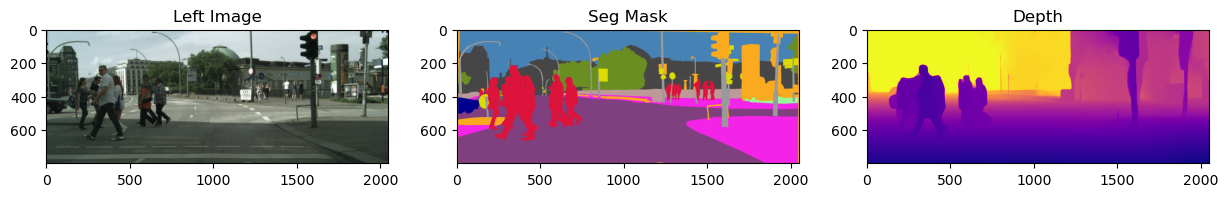

In [205]:
plot_items(left, mask, depth.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

1/4 res model prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


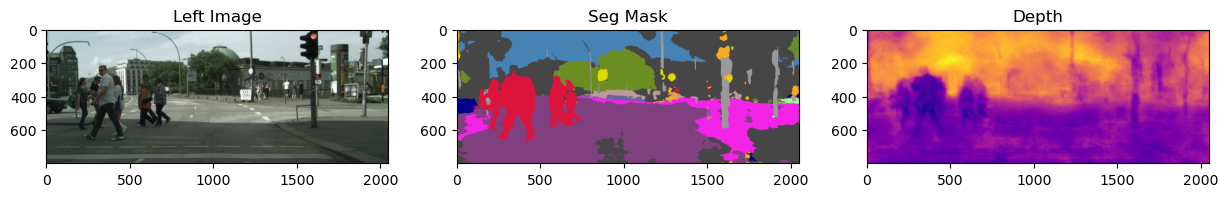

In [206]:
plot_items(left, pred_seg_4.argmax(dim=1).squeeze(0), pred_depth_4.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

1/2 res model prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


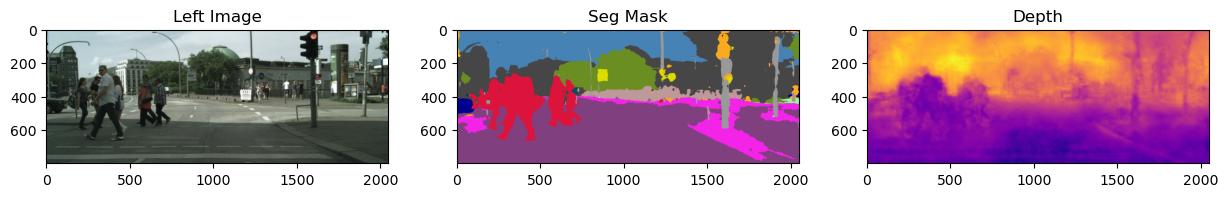

In [207]:
plot_items(left, pred_seg_2.argmax(dim=1).squeeze(0), pred_depth_2.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

full res model prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


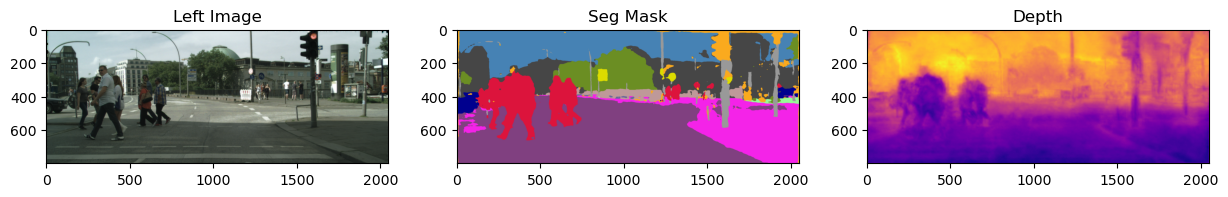

In [208]:
plot_items(left, pred_seg.argmax(dim=1).squeeze(0), pred_depth.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

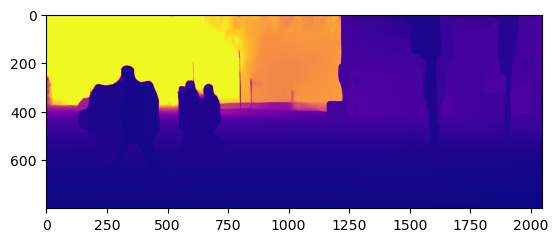

In [209]:
plt.imshow(convert_to_numpy(torch.exp(depth*5)), cmap='plasma')

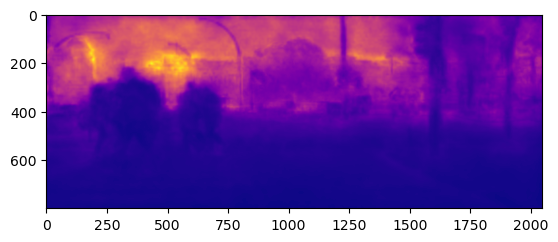

In [210]:
plt.imshow(convert_to_numpy(torch.exp(pred_depth.squeeze(0)*5)), cmap='plasma')